In [1]:
import treecorr
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

# these are the GLASS imports: cosmology and everything in the glass namespace
from astropy.io import fits
import healpy as hp
# also needs camb itself to get the parameter object

import sys
sys.path.append('../src')
import glass_mock
from importlib import reload
reload(glass_mock)
import generate_mocksys
reload(generate_mocksys)
import glass.shells

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

# Define some simple selection functions

In [2]:
p1 = np.poly1d([-0.2, 1, 0.5])
p2 = np.poly1d([0.3, 0.7])
p3_tri = generate_mocksys.trig_func(0.01, 0.5, 0, 0.8)
p3_lin = np.poly1d([0.15, 0])
p3 = lambda x: p3_tri(x)+p3_lin(x)

deplfuncs = [p1, p2, p3]

# Define the configuration for GLASS

In [3]:
import camb

# cosmology for the simulation
h = 0.7
Oc = 0.25
Ob = 0.05
ns = 0.96
sigma8 = 0.8
bias = 1

# basic parameters of the simulation
nside = 2048
lmax = nside * 3

# create a cosmology object
# uniform (in volume) source distribution with given angular density
# galaxy density
n_arcmin2 = 1.0

z = np.linspace(0, 2, 201)
dz = (z[-1]-z[0])/z.size
dndz = np.exp(-(z-0.3)**2/2/0.1**2)   # assume some simple n(z)
dndz /= (dndz.sum()*dz)

zb = glass.shells.redshift_grid(z[0], z[-1], dz=0.1)
# tophat window functions for shells
ws = glass.shells.tophat_windows(zb, dz=0.01)
pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2, WantTransfer = True, NonLinear=camb.model.NonLinear_both, halofit_version='takahashi')
#%time cls = glass.ext.camb.matter_cls(pars, lmax, ws, limber=True, limber_lmin=0)
#%time gls = glass.fields.lognormal_gls(cls, lmax=4320)  # uncomment this line if you want to calculate gls but this will take time.
# np.savetxt('../../data/mock_gls.npy', gls)

gls = np.loadtxt('../../data/mock_gls.npy')

# Define the configuration of tiles

In [4]:
vec_vertices = hp.ang2vec(np.array([0, 0, 100, 100]), np.array([5, -5, -5, 5]), lonlat=True)
vis = np.zeros(hp.nside2npix(nside))
vis[hp.query_polygon(nside, vec_vertices)] = 1
vis_weight = vis.copy()  # here we assume that all the pixel is fully observed, which might not be true in real case, for which one needs a "vis_weight" map to specify the coverage of each pixel on the healpix map.

dx = 1
dy = 1
nlon = 100
nlat = 10
start_lon = 0
start_lat = -5

test_tiles = generate_mocksys.tiles(start_lon, start_lat, dx, dy, nlon, nlat)

# Define three types of systematics and corresponding keeping functions

In [5]:
config_sys_a = {'lat_sys_center': -5,
                'lon_sys_center': 5,
                'cov_xx': .0001,
                'cov_yy': .01,
                'cov_xy': 0}

config_sys_b = {'xmean_fluc':.1,
                'ymean_fluc':.1,
                'covxx_mean': 10,
                'covyy_mean': 10,
                'covxx_fluc': 1,
                'covyy_fluc': 1,
                'covxy_fluc': 4,
                'amp': -0.1,
                'shift': 1}

config_sys_c = {'upper': 1,
                'lower': 0.2}

sys_names = ['sa', 'sb', 'sc']  
sys_depfuncs = {'sa':lambda x: 1-p1(x), 'sb': lambda x: 1-p2(x), 'sc': lambda x: 1-p3(x)}

systematics = {'sa':generate_mocksys.type_A_sys(test_tiles, config_sys_a),
                'sb':generate_mocksys.type_B_sys(test_tiles, config_sys_b),
                'sc':generate_mocksys.type_C_sys(test_tiles, config_sys_c)}


# Load mock galaxy catalog and uniform random catalog

To generate GLASS mock catalog, just uncomment the two glass_mock.glass_mock lines. 
You can also download the mock data from https://drive.google.com/file/d/1HBLsk76OWRiGj_fyBVwpMWaomw3flQ__/view?usp=sharing

In [6]:
reload(glass_mock)

glasscat = f'../../data/glass_testgalcat_density_{n_arcmin2}.fits'
glasscat_unirand = f'../../data/glass_testgalcat_rand_density_{n_arcmin2}.fits'

glass_mock.glass_mock(Oc, Ob, h, bias, z, n_arcmin2, dndz, vis, nside, glasscat, gls=gls)
glass_mock.glass_mock(Oc, Ob, h, bias, z, n_arcmin2, dndz, vis, nside, glasscat_unirand, gls=gls, random=True)

## Load the galaxies generated mock sample

In [7]:
mockcat = fits.open(glasscat)
redshift_test = mockcat[1].data['Redshift']
lons_test = mockcat[1].data['RA']
lats_test = mockcat[1].data['Dec']

mockcat_unirand = fits.open(glasscat_unirand)
redshift_test_unirand = mockcat_unirand[1].data['Redshift']
lons_test_unirand = mockcat_unirand[1].data['RA']
lats_test_unirand = mockcat_unirand[1].data['Dec']

## Put them in tiles

In [8]:
source_tileind = test_tiles.get_tileind(lons_test, lats_test)
source_tileind_unirand = test_tiles.get_tileind(lons_test_unirand, lats_test_unirand)

col_tileind = fits.Column(name='Tile_ind', format='D', array = source_tileind)
col_tileind_unirand = fits.Column(name='Tile_ind', format='D', array = source_tileind_unirand)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:45<00:00, 22.16it/s]


## Cut out galaxies that are outside of all tiles

In [9]:
lons_test = lons_test[source_tileind!=-1]
lats_test = lats_test[source_tileind!=-1]

lons_test_unirand = lons_test_unirand[source_tileind_unirand!=-1]
lats_test_unirand = lats_test_unirand[source_tileind_unirand!=-1]

source_tileind = source_tileind[source_tileind!=-1]
source_tileind_unirand = source_tileind_unirand[source_tileind_unirand!=-1]

## and add the systematics and selection probabilities

In [10]:
glasscat_wsys = f'../../data/glass_testgalcat_depl.fits'
keep = np.ones(lons_test.size).astype('bool')
col_RA = fits.Column(name='RA', format='D', array=lons_test)
col_Dec = fits.Column(name='Dec', format='D', array=lats_test)
col_list = [col_RA, col_Dec, col_tileind]
source_sys = {}

for sys_name in sys_names:
    print(sys_name)
    source_sys[sys_name], _, keep_ = systematics[sys_name](lons_test, lats_test, source_tileind, sys_depfuncs[sys_name], normed=True)
    keep &= keep_
    col_list.append(fits.Column(name=sys_name, format='D', array=source_sys[sys_name]))

sa
sb


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 294.98it/s]


sc


# Perform selections to the mock sample

In [11]:
hp_ind = hp.ang2pix(nside, lons_test, lats_test, lonlat=True)
frac_keep = np.mean(keep)

rand_val = np.random.rand(hp_ind.size)
col_list.append(fits.Column(name='keep_sys', format='D', array=keep))

ds_val = np.random.rand(lons_test.size)
keep_ds = (ds_val<frac_keep)

rand_val = np.random.rand(hp_ind.size)
col_list.append(fits.Column(name='keep_desample', format='D', array=keep_ds))

newhdu = fits.BinTableHDU.from_columns(col_list)
hdul = fits.HDUList([mockcat[0], newhdu])
hdul.writeto(glasscat_wsys, overwrite=True)

## then put them into Healpix scheme

## Save the pixelized catalogs:
    
    - `Nmap_unbiased` is the galaxy catalog selected with uniform selection function, so that it has the same mean galaxy number as the anisotropically selected sample;
    - `Nmap_depleted` is the galaxy catalog selected with the systematics selection function. 

In [12]:
Ns_Nmap = 1024
Ns_wmap = 1024

In [13]:
hp_idx_unbiased = hp.ang2pix(Ns_Nmap, lons_test[keep_ds], lats_test[keep_ds], lonlat=True)
Nmap_unbiased = np.zeros(hp.nside2npix(Ns_Nmap))
np.add.at(Nmap_unbiased, hp_idx_unbiased, 1)
hpcat_unbiased = f'../../data/glass_Ns_{Ns_Nmap}_sample_unbiased.fits'
glass_mock.hpmap_to_hpcat(Nmap_unbiased, hpcat_unbiased, Ns_Nmap)

hp_idx_depleted = hp.ang2pix(Ns_Nmap, lons_test[keep], lats_test[keep], lonlat=True)
Nmap_depleted = np.zeros(hp.nside2npix(Ns_Nmap))
np.add.at(Nmap_depleted , hp_idx_depleted , 1)
hpcat_depleted = f'../../data/glass_Ns_{Ns_Nmap}_sample_depleted.fits'
glass_mock.hpmap_to_hpcat(Nmap_depleted, hpcat_depleted, Ns_Nmap)

area_survey = np.nonzero(Nmap_depleted)[0].size * hp.nside2pixarea(Ns_Nmap, degrees=True)
N_galaxies = np.sum(Nmap_depleted)
n_eff = N_galaxies / area_survey / 3600
    
print(f"footprint area is {area_survey} degree^2.")
print(f"n_eff = {n_eff} arcmin^-1.")

303461 pixels contain galaxies!
303112 pixels contain galaxies!
footprint area is 993.7499038564343 degree^2.
n_eff = 0.7026837856633651 arcmin^-1.


## do the same thing for the random catalog

In [14]:
glasscat_unirand_wsys = f'../../data/glass_testrandcat_depl.fits'

keep_unirand = np.ones(lons_test_unirand.size).astype('bool')
col_RA_unirand = fits.Column(name='RA', format='D', array=lons_test_unirand)
col_Dec_unirand = fits.Column(name='Dec', format='D', array=lats_test_unirand)
col_list_unirand = [col_RA_unirand, col_Dec_unirand, col_tileind_unirand]
source_sys_unirand = {}

for sys_name in sys_names:
    source_sys_unirand[sys_name], _, keep_unirand_ = systematics[sys_name](lons_test_unirand, lats_test_unirand, source_tileind_unirand, sys_depfuncs[sys_name], normed=True)
    keep_unirand &= keep_unirand_
    col_list_unirand.append(fits.Column(name=sys_name, format='D', array=source_sys_unirand[sys_name]))


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 288.20it/s]


In [15]:
hp_ind_unirand = hp.ang2pix(nside, lons_test_unirand, lats_test_unirand, lonlat=True)
rand_val_unirand = np.random.rand(hp_ind_unirand.size)
frac_keep_unirand = np.mean(keep_unirand)

col_list_unirand.append(fits.Column(name='keep_sys', format='D', array=keep_unirand))

ds_val_unirand = np.random.rand(lons_test_unirand.size)
keep_ds_unirand = (ds_val_unirand<frac_keep_unirand)
rand_val = np.random.rand(hp_ind_unirand.size)
col_list_unirand.append(fits.Column(name='keep_desample', format='D', array=keep_ds_unirand))

newhdu_unirand = fits.BinTableHDU.from_columns(col_list_unirand)
hdul = fits.HDUList([mockcat_unirand[0], newhdu_unirand])
hdul.writeto(glasscat_unirand_wsys, overwrite=True)

## Save the pixelized catalogs:
    
    - `URmap` is the random catalog selected with uniform selection function, so that it has the same mean galaxy number as the anisotropically selected sample;
    - `ORmap_trueOR` is the random catalog selected with the same systematics selection function. This represents the 'true organized random' that we want to recover

In [16]:
hp_idx_ur_unbiased = hp.ang2pix(Ns_Nmap, lons_test_unirand[keep_ds_unirand], lats_test_unirand[keep_ds_unirand], lonlat=True)
URmap = np.zeros(hp.nside2npix(Ns_Nmap))
np.add.at(URmap, hp_idx_ur_unbiased, 1)
hpcat_ur_unbiased = f'../../data/glass_Ns_{Ns_Nmap}_sample_UR_unbiased.fits'
glass_mock.hpmap_to_hpcat(URmap, hpcat_ur_unbiased, Ns_Nmap)

hp_idx_trueOR = hp.ang2pix(Ns_Nmap, lons_test_unirand[keep_unirand], lats_test_unirand[keep_unirand], lonlat=True)
ORmap_trueOR = np.zeros(hp.nside2npix(Ns_Nmap))
np.add.at(ORmap_trueOR, hp_idx_trueOR, 1)
hpcat_trueOR = f'../../data/glass_Ns_{Ns_Nmap}_sample_OR_true.fits'
glass_mock.hpmap_to_hpcat(ORmap_trueOR, hpcat_trueOR, Ns_Nmap)

area_survey = np.nonzero(ORmap_trueOR)[0].size * hp.nside2pixarea(Ns_Nmap, degrees=True)
N_galaxies = np.sum(URmap)
n_eff = N_galaxies / area_survey / 3600
    
print(f"footprint area is {area_survey} degree^2.")
print(f"n_eff = {n_eff} arcmin^-1.")

304103 pixels contain galaxies!
303919 pixels contain galaxies!
footprint area is 996.3956459333305 degree^2.
n_eff = 0.7003127863505343 arcmin^-1.


# Construct training data for SOM+HC

In [17]:
for i, sys in enumerate(sys_names):
    print(sys)
    if i == 0:
        raw_data = source_sys[sys][keep]
    else:
        raw_data = np.vstack([raw_data, source_sys[sys][keep]])
raw_data = raw_data.T      
raw_data = (raw_data - np.min(raw_data, axis=0)) / (np.max(raw_data, axis=0)-np.min(raw_data, axis=0))

radec = np.vstack([lons_test[keep], lats_test[keep]]).T

sa
sb
sc


In [18]:
training_data = raw_data#[mask_training]
training_radec = radec#[mask_training]

# Set up a SOM and train it

In [19]:
import OR_weights
reload(OR_weights)
from OR_weights import *
import somoclu

som_dim = 100
topology = 'hexagonal'

som = somoclu.Somoclu(som_dim, som_dim, gridtype=topology, maptype='toroid', initialization='pca',
                      compactsupport=False)

s2s = som2stats(som)

In [20]:
%time s2s.train_som(training_data)

CPU times: user 4h 53min 21s, sys: 55 s, total: 4h 54min 16s
Wall time: 2min 49s


In [21]:
s2s.get_OR_info(training_radec)
s2s.get_sys_maps()

/net/home/fohlen14/yanza21/research/src/tiaogeng/codes/notebook/../src/OR_weights.py:119: RuntimeWarning: invalid value encountered in divide
  sys_maps /= n_maps[:,:,None]


In [22]:
Nmap = s2s.get_test_hp_Nmap(Ns=Ns_Nmap)
s2s.hierarchical_clustering(n_cluster=400)
wmap, ncontrast_som=s2s.calculate_or_weights(Ns_wmap)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 992.71it/s]

Fraction of occupied pixels: 1.0


sa
sb
sc


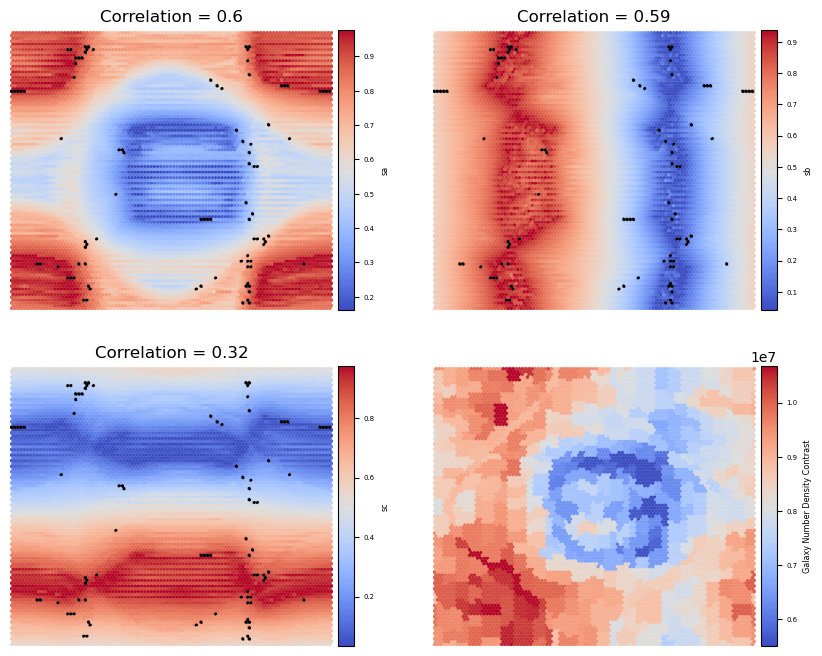

In [23]:
import matplotlib.pyplot as plt

from plot_som import *
n_syst = len(sys_names)

f, axes = plt.subplots(ncols=2, nrows=int(n_syst/2)+1, figsize=(10*2/(int(n_syst/2)+1), 8))
sys_maps = s2s.sys_maps
corr_dict = {}

for i in range(n_syst):
    print(sys_names[i])
    a = sys_maps[:,:,i].reshape(-1)[~np.isnan(sys_maps[:,:,i].reshape(-1))]
    b = ncontrast_som.reshape(-1)[~np.isnan(sys_maps[:,:,i].reshape(-1))]
    corr = round(np.corrcoef(a, b)[0,1],2)
    corr_dict[sys_names[i]] = corr
    ax = axes.flatten()[i]
    ax.set_title('Correlation = '+str(corr))
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    plot_som(ax, sys_maps[:,:,i], topology=topology, colormap=cm.coolwarm, cbar_name=sys_names[i])
    
ax = axes.flatten()[-1]
ax.set_aspect('equal')
plot_som(ax, ncontrast_som, topology=topology, colormap=cm.coolwarm, 
         cbar_name='Galaxy Number Density Contrast')
ax.set_xticks([])
ax.set_yticks([])

if n_syst % 2 == 0:
    axes.flatten()[-2].set_visible(False)

# perform HC and recover the OR weight map

## save the recovered OR map for w($\theta$) measurement

In [24]:
hpcat_orweight = f'../../data/glass_Ns_{Ns_Nmap}_sample_orweight.fits'
glass_mock.hpmap_to_hpcat(hp.ud_grade(wmap, Ns_Nmap), hpcat_orweight, Ns_Nmap)

303112 pixels contain galaxies!


## Compare the recovered OR weights with the true OR weights given by known depletion functions

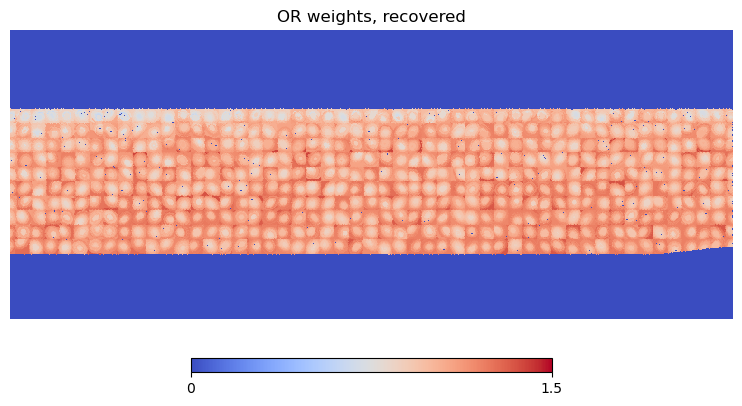

In [25]:
lonras=[0, 50]
latras=[-10,10]
delta_map_somor = wmap/(np.mean(wmap[np.nonzero(wmap)[0]]))-1
ms=hp.cartview(delta_map_somor+1, return_projected_map=True, lonra=lonras, latra=latras, max=1.5, title='OR weights, recovered',cmap='coolwarm')

## pixelize the depletion function

In [27]:
lon_hp, lat_hp = hp.pix2ang(Ns_wmap, np.where(wmap>0)[0], lonlat=True)
tileind_hp = test_tiles.get_tileind(lon_hp, lat_hp)

keep_hp = np.ones(lon_hp.size)

for sys_name in sys_names:
    print(sys_name)
    
    _, depl_, _ = systematics[sys_name](lon_hp, lat_hp, tileind_hp, sys_depfuncs[sys_name], normed=True)
    keep_hp *= (1-depl_)

keep_map = np.zeros_like(wmap)
keep_map[np.where(wmap>0)[0]] = keep_hp
keep_map[np.isnan(keep_map)] = 0

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 921.65it/s]


sa
sb


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5599.51it/s]


sc


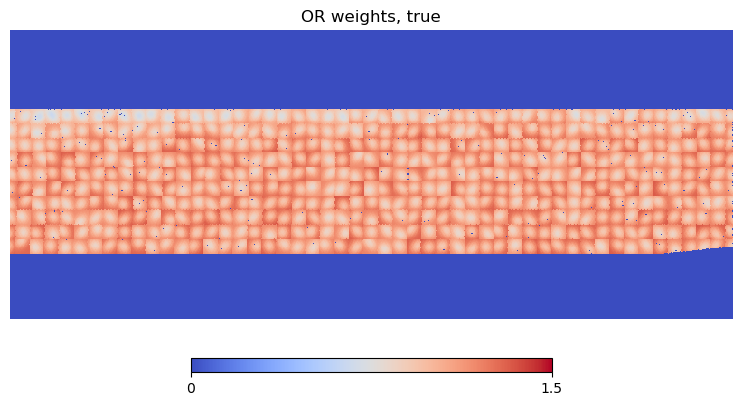

In [28]:
lonras=[0, 50]
latras=[-10,10]
delta_map_trueor = keep_map/(np.mean(keep_map[np.nonzero(keep_map)[0]]))-1
ms=hp.cartview(delta_map_trueor+1, return_projected_map=True, lonra=lonras, latra=latras, max=1.5, title='OR weights, true',cmap='coolwarm')

# Calculate $w(\theta)$ with `treecorr`

## Use the reconstructed OR as random sample with depleted galaxy sample:

In [29]:
import treecorr
from treecorr_utils import *

catd_depleted = treecorr.Catalog(hpcat_depleted, ra_col="RA", dec_col="Dec", w_col='Delta', ra_units='deg', dec_units='deg', npatch=30)
catr_som_or = treecorr.Catalog(hpcat_orweight, ra_col="RA", dec_col="Dec", w_col='Delta', ra_units='deg', dec_units='deg', patch_centers=catd_depleted.patch_centers)
theta_som_hp_or , w_som_hp_or, cov_som_hp_or = treecorr_NNcor(catd_depleted, catr_som_or, nbins=20, max_sep=250, min_sep = 2.5, var_method='bootstrap')

## Use a uniform random sample with depleted galaxy sample:

In [30]:
catr_true_or = treecorr.Catalog(hpcat_trueOR, ra_col="RA", dec_col="Dec", w_col='Delta', ra_units='deg', dec_units='deg', patch_centers=catd_depleted.patch_centers)
catr_ur = treecorr.Catalog(hpcat_ur_unbiased, ra_col="RA", dec_col="Dec", w_col='Delta', ra_units='deg', dec_units='deg', patch_centers=catd_depleted.patch_centers)
theta_ur , w_ur, cov_ur = treecorr_NNcor(catd_depleted, catr_ur, nbins=20, max_sep=250, min_sep = 2.5, var_method='bootstrap')

## Use a depleted random sample (by the true OR) with depleted galaxy sample:

In [31]:
theta_true_or , w_true_or, cov_true_or = treecorr_NNcor(catd_depleted, catr_true_or, nbins=20, max_sep=250, min_sep = 2.5, var_method='bootstrap')

## Use a uniform random sample with uniformly depleted galaxy sample

In [32]:
catd_unbiased = treecorr.Catalog(hpcat_unbiased, ra_col="RA", dec_col="Dec", w_col='Delta', ra_units='deg', dec_units='deg', patch_centers=catd_depleted.patch_centers)
catr_unbiased = treecorr.Catalog(hpcat_ur_unbiased, ra_col="RA", dec_col="Dec", w_col='Delta', ra_units='deg', dec_units='deg', patch_centers=catd_depleted.patch_centers)
theta_unbiased, w_unbiased, cov_unbiased = treecorr_NNcor(catd_unbiased, catr_unbiased, nbins=20, max_sep=250, min_sep = 2.5, var_method='bootstrap')

# Calculate theoretical $w(\theta)$

In [33]:
import pyccl

cosmo_pyccl = pyccl.Cosmology(Omega_c=Oc, Omega_b=Ob, h=h, n_s=0.96, A_s = pars.InitPower.As)
gtracer = pyccl.NumberCountsTracer(cosmo_pyccl, has_rsd=False, dndz=(z, dndz), bias=(z, np.ones_like(z)))

ell = np.linspace(0, 5000, 5000)
cell = pyccl.angular_cl(cosmo_pyccl, gtracer, gtracer, ell)
w_theory = pyccl.correlation(cosmo_pyccl, ell, cell, theta_ur/60)

# Plot them!

Text(0, 0.5, '$\\theta w(\\theta)$')

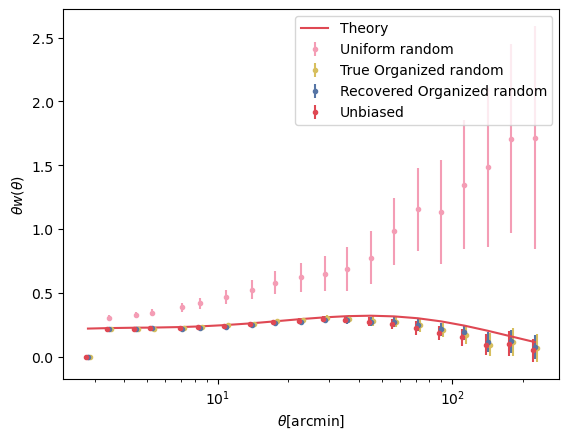

In [34]:
colors_btr = {'ur': '#f49db5',
              'true_or': '#d7bf5e',
              'som_or':'#5675a5',
              'unbiased':'#df4853',
              'black':'k'}

w_theory = pyccl.correlation(cosmo_pyccl, ell, cell, theta_ur/60)
plt.errorbar(theta_ur, theta_ur*w_ur, label='Uniform random', yerr=theta_ur * np.diag(cov_ur) ** 0.5, fmt='.', color=colors_btr['ur'])
plt.errorbar(theta_true_or*1.02, theta_true_or*w_true_or, label='True Organized random', yerr=theta_true_or * np.diag(cov_true_or) ** 0.5, fmt='.', color=colors_btr['true_or'])
plt.errorbar(theta_som_hp_or, theta_som_hp_or*w_som_hp_or, label='Recovered Organized random', yerr=theta_som_hp_or * np.diag(cov_som_hp_or) ** 0.5, fmt='.', color=colors_btr['som_or'])
plt.errorbar(theta_unbiased/1.02, theta_unbiased*w_unbiased, label='Unbiased', yerr=theta_unbiased * np.diag(cov_unbiased) ** 0.5, fmt='.', color=colors_btr['unbiased'])
plt.xscale('log')
plt.semilogx(theta_ur, theta_ur*w_theory, label='Theory', color=colors_btr['unbiased'])
plt.legend()
plt.xlabel(r'$\theta$[arcmin]')
plt.ylabel(r'$\theta w(\theta)$')
#plt.yscale('log')
#plt.axvline(pixscale*2**0.5, 0, 1, color='k')
#plt.ylim(0.01, 30)

/tmp/ipykernel_2466853/966194559.py:2: RuntimeWarning: invalid value encountered in divide
  plt.errorbar(theta_true_or*1.02, w_true_or/w_unbiased, label='True Organized random', yerr=np.diag(cov_true_or) ** 0.5/w_unbiased, fmt='.', color=colors_btr['true_or'])
/tmp/ipykernel_2466853/966194559.py:3: RuntimeWarning: invalid value encountered in divide
  plt.errorbar(theta_som_hp_or, w_som_hp_or/w_unbiased, label='Recovered Organized random', yerr=np.diag(cov_som_hp_or) ** 0.5/w_unbiased, fmt='.', color=colors_btr['som_or'])
/tmp/ipykernel_2466853/966194559.py:4: RuntimeWarning: invalid value encountered in divide
  plt.errorbar(theta_unbiased/1.02, w_unbiased/w_unbiased, label='Unbiased', yerr=np.diag(cov_unbiased) ** 0.5/w_unbiased, fmt='.', color=colors_btr['unbiased'])


(0.0, 2.0)

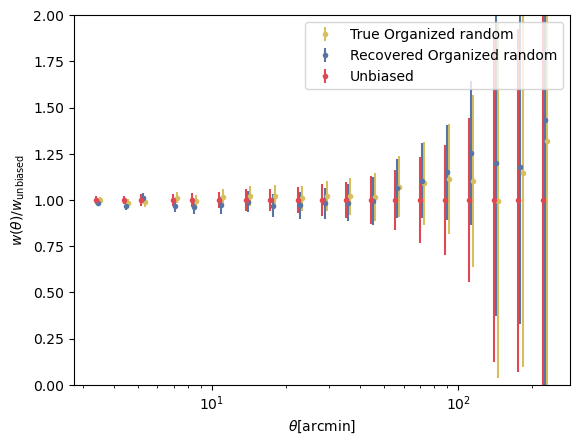

In [35]:
w_theory = pyccl.correlation(cosmo_pyccl, ell, cell, theta_ur/60)
plt.errorbar(theta_true_or*1.02, w_true_or/w_unbiased, label='True Organized random', yerr=np.diag(cov_true_or) ** 0.5/w_unbiased, fmt='.', color=colors_btr['true_or'])
plt.errorbar(theta_som_hp_or, w_som_hp_or/w_unbiased, label='Recovered Organized random', yerr=np.diag(cov_som_hp_or) ** 0.5/w_unbiased, fmt='.', color=colors_btr['som_or'])
plt.errorbar(theta_unbiased/1.02, w_unbiased/w_unbiased, label='Unbiased', yerr=np.diag(cov_unbiased) ** 0.5/w_unbiased, fmt='.', color=colors_btr['unbiased'])
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\theta$[arcmin]')
plt.ylabel(r'$w(\theta)/w_{\mathrm{unbiased}}$')
plt.ylim(0, 2)

## also plot the standard deviations

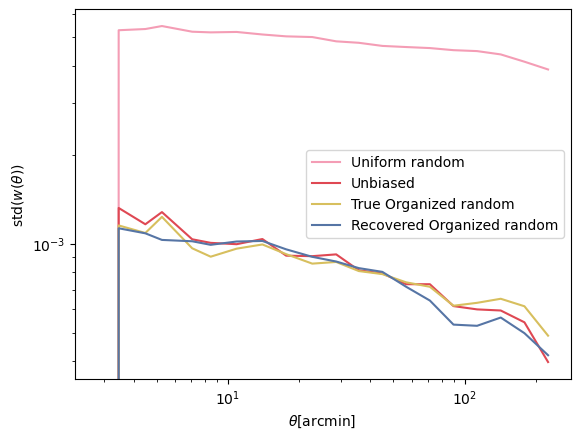

In [36]:

w_theory = pyccl.correlation(cosmo_pyccl, ell, cell, theta_ur/60)
plt.plot(theta_ur, np.diag(cov_ur) ** 0.5, label='Uniform random', color=colors_btr['ur'])
plt.plot(theta_unbiased, np.diag(cov_unbiased) ** 0.5, label='Unbiased', color=colors_btr['unbiased'])
plt.plot(theta_true_or, np.diag(cov_true_or) ** 0.5, label='True Organized random', color=colors_btr['true_or'])
plt.plot(theta_som_hp_or, np.diag(cov_som_hp_or) ** 0.5, label='Recovered Organized random', color=colors_btr['som_or'])
plt.legend()
plt.xlabel(r'$\theta$[arcmin]')
plt.ylabel(r'std$(w(\theta))$')
plt.yscale('log')
plt.xscale('log')